# WSDM - KKBox's Churn Prediction Challenge

## Import library

In [216]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import roc_auc_score,confusion_matrix,roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

import datetime as dt

% matplotlib inline
seed = 129

## Import Dataset

In [217]:
#path = '../input/'
path = 'dataset/'
nrows =100000
#nrows =None
train = pd.read_csv(path+'train_v2.csv',nrows=nrows, dtype={'is_churn':np.int8})
test = pd.read_csv(path+'sample_submission_v2.csv',nrows=nrows,dtype={'is_churn':np.int8})
members = pd.read_csv(path+'members_v3.csv',nrows=nrows,parse_dates=['registration_init_time'],dtype={'city':np.int8,'bd':np.int8,
                                                                                         'registered_via':np.int8})
transactions = pd.read_csv(path+'transactions_v2.csv',nrows=nrows,parse_dates=['transaction_date','membership_expire_date'],
                          dtype={'payment_method_id':np.int8,'payment_plan_days':np.int8,'plan_list_price':np.int8,
                                'actual_amount_paid':np.int8,'is_auto_renew':np.int8,'is_cancel':np.int8})

user_log = pd.read_csv(path+'user_logs_v2.csv',nrows=nrows,parse_dates=['date'],dtype={'num_25':np.int16,'num_50':np.int16,
                                    'num_75':np.int16,'num_985':np.int16,'num_100':np.int16,'num_unq':np.int16})

## Explore data set

In [218]:
print('Number of rows  & columns',train.shape)
train.head()

Number of rows  & columns (100000, 2)


,msno,is_churn
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1


In [219]:
print('Number of rows  & columns',test.shape)
test.head()

Number of rows  & columns (100000, 2)


,msno,is_churn
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=,0
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=,0
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=,0
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=,0
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=,0


In [220]:
print('Number of rows  & columns',members.shape)
members.head()

Number of rows  & columns (100000, 6)


,msno,city,bd,gender,registered_via,registration_init_time
0,Rb9UwLQTrxzBVwCB6+bCcSQWZ9JiNLC9dXtM1oEsZA8=,1,0,NaN,11,2011-09-11
1,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0,NaN,7,2011-09-14
2,cV358ssn7a0f7jZOwGNWS07wCKVqxyiImJUX6xcIwKw=,1,0,NaN,11,2011-09-15
3,9bzDeJP6sQodK73K5CBlJ6fgIQzPeLnRl0p5B77XP+g=,1,0,NaN,11,2011-09-15
4,WFLY3s7z4EZsieHCt63XrsdtfTEmJ+2PnnKLH5GY4Tk=,6,32,female,9,2011-09-15


In [221]:
print('Number of rows & columns',transactions.shape)
transactions.head()

Number of rows & columns (100000, 9)


,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,++6eU4LsQ3UQ20ILS7d99XK8WbiVgbyYL4FUgzZR134=,32,90,42,42,0,2017-01-31,2017-05-04,0
1,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,-107,-107,1,2015-08-09,2019-04-12,0
2,+/GXNtXWQVfKrEDqYAzcSw2xSPYMKWNj22m+5XkVQZc=,36,30,-76,-76,1,2017-03-03,2017-04-22,0
3,+/w1UrZwyka4C9oNH3+Q8fUf3fD8R3EwWrx57ODIsqk=,36,30,-76,-76,1,2017-03-29,2017-03-31,1
4,+00PGzKTYqtnb65mPKPyeHXcZEwqiEzktpQksaaSC3c=,41,30,99,99,1,2017-03-23,2017-04-23,0


In [222]:
print('Number of rows & columns',user_log.shape)
user_log.head()

Number of rows & columns (100000, 9)


,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,u9E91QDTvHLq6NXjEaWv8u4QIqhrHk72kE+w31Gnhdg=,2017-03-31,8,4,0,1,21,18,6309.273
1,nTeWW/eOZA/UHKdD5L7DEqKKFTjaAj3ALLPoAWsU8n0=,2017-03-30,2,2,1,0,9,11,2390.699
2,2UqkWXwZbIjs03dHLU9KHJNNEvEkZVzm69f3jCS+uLI=,2017-03-31,52,3,5,3,84,110,23203.337
3,ycwLc+m2O0a85jSLALtr941AaZt9ai8Qwlg9n0Nql5U=,2017-03-31,176,4,2,2,19,191,7100.454
4,EGcbTofOSOkMmQyN1NMLxHEXJ1yV3t/JdhGwQ9wXjnI=,2017-03-31,2,1,0,1,112,93,28401.558


In [223]:
print('\nTrain:',train.describe().T)
print('\nTest:',test.describe().T)
print('\nMembers:',members.describe().T)
print('\nTransactions:',transactions.describe().T)
print('\nUser log:',user_log.describe().T)



Train:              count    mean       std  min  25%  50%  75%  max
is_churn  100000.0  0.5233  0.499459  0.0  0.0  1.0  1.0  1.0

Test:              count  mean  std  min  25%  50%  75%  max
is_churn  100000.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0

Members:                    count      mean        std    min  25%  50%   75%    max
city            100000.0   4.21193   5.721570    1.0  1.0  1.0   5.0   22.0
bd              100000.0  10.80096  15.853796 -101.0  0.0  0.0  23.0  117.0
registered_via  100000.0   5.47079   2.462512    2.0  4.0  4.0   9.0   19.0

Transactions:                        count      mean        std    min    25%   50%   75%  \
payment_method_id   100000.0  37.91340   4.956516    3.0   36.0  40.0  41.0   
payment_plan_days   100000.0  18.44352  39.797074 -117.0   30.0  30.0  30.0   
plan_list_price     100000.0 -21.83432  94.701296 -127.0 -107.0 -76.0  99.0   
actual_amount_paid  100000.0 -21.04312  94.849653 -127.0 -107.0 -76.0  99.0   
is_auto_renew       100000.

## Merge data set

In [224]:
train = pd.merge(train,members,on='msno',how='left')
test = pd.merge(test,members,on='msno',how='left')
train = pd.merge(train,transactions,how='left',on='msno',left_index=True, right_index=True)
test = pd.merge(test,transactions,how='left',on='msno',left_index=True, right_index=True,)
train = pd.merge(train,user_log,how='left',on='msno',left_index=True, right_index=True)
test = pd.merge(test,user_log,how='left',on='msno',left_index=True, right_index=True)

del members,transactions,user_log
print('Number of rows & columns',train.shape)
print('Number of rows & columns',test.shape)


Number of rows & columns (100000, 23)
Number of rows & columns (100000, 23)


## Date feature

In [225]:
train[['registration_init_time' ,'transaction_date','membership_expire_date','date']].describe()

,registration_init_time,transaction_date,membership_expire_date,date
count,1474,100000,100000,100000
unique,1042,797,1073,31
top,2017-02-13 00:00:00,2017-03-31 00:00:00,2017-04-30 00:00:00,2017-03-30 00:00:00
freq,7,13419,8105,3367
first,2004-03-26 00:00:00,2015-01-01 00:00:00,2016-04-20 00:00:00,2017-03-01 00:00:00
last,2017-03-28 00:00:00,2017-03-31 00:00:00,2027-09-28 00:00:00,2017-03-31 00:00:00


In [226]:
train[['registration_init_time' ,'transaction_date','membership_expire_date','date']].isnull().sum()

registration_init_time    98526
transaction_date              0
membership_expire_date        0
date                          0
dtype: int64

In [227]:
train['registration_init_time'] = train['registration_init_time'].fillna(value=pd.to_datetime('09/10/2015'))
test['registration_init_time'] = test['registration_init_time'].fillna(value=pd.to_datetime('09/10/2015'))

In [228]:
def date_feature(df):
    
    col = ['registration_init_time' ,'transaction_date','membership_expire_date','date']
    var = ['reg','trans','mem_exp','user_']
    #df['duration'] = (df[col[1]] - df[col[0]]).dt.days 
    
    for i ,j in zip(col,var):
        df[j+'_day'] = df[i].dt.day.astype('uint8')
        df[j+'_weekday'] = df[i].dt.weekday.astype('uint8')        
        df[j+'_month'] = df[i].dt.month.astype('uint8') 
        df[j+'_year'] =df[i].dt.year.astype('uint16') 

date_feature(train)
date_feature(test)

## Data analysis 

In [229]:
train.columns

Index(['msno', 'is_churn', 'city', 'bd', 'gender', 'registered_via',
       'registration_init_time', 'payment_method_id', 'payment_plan_days',
       'plan_list_price', 'actual_amount_paid', 'is_auto_renew',
       'transaction_date', 'membership_expire_date', 'is_cancel', 'date',
       'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq',
       'total_secs', 'reg_day', 'reg_weekday', 'reg_month', 'reg_year',
       'trans_day', 'trans_weekday', 'trans_month', 'trans_year',
       'mem_exp_day', 'mem_exp_weekday', 'mem_exp_month', 'mem_exp_year',
       'user__day', 'user__weekday', 'user__month', 'user__year'],
      dtype='object')

# Missing value

In [230]:
def basic_details(df):
    k = pd.DataFrame()
    k['N unique values'] = df.nunique()
    k['Misssing value'] = df.isnull().sum()
    k['dtype'] = df.dtypes
    return k

In [231]:
basic_details(train) 

,N unique values,Misssing value,dtype
msno,100000,0,object
is_churn,2,0,int8
city,20,98526,float64
bd,49,98526,float64
gender,2,99143,object
registered_via,5,98526,float64
registration_init_time,1042,0,datetime64[ns]
payment_method_id,34,0,int8
payment_plan_days,29,0,int8
plan_list_price,39,0,int8


In [232]:
col = [ 'city', 'bd', 'gender', 'registered_via']
def missing(df,columns):
    col = columns
    for i in col:
        df[i].fillna(df[i].mode()[0],inplace=True)

missing(train,col)
missing(test,col)

# is_churn

Text(0.5,0,'The subscription within 30 days of expiration is True/False')

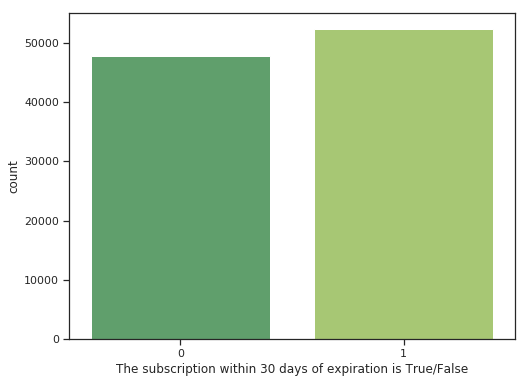

In [233]:
plt.figure(figsize=(8,6))
sns.set_style('ticks')
sns.countplot(train['is_churn'],palette='summer')
plt.xlabel('The subscription within 30 days of expiration is True/False')

Imbalanced data set

msno: user id

is_churn: This is the target variable. Churn is defined as whether the user did not continue the subscription within 30 days of expiration. 
is_churn = 1 means churn,is_churn = 0 means renewal.

## Univariate analysis

[  1.  13.  21.   4.   6.   5.  22.  15.  12.  10.   9.  14.  16.   8.  17.
  11.  18.   3.   7.  20.]


Text(0.5,0,'Payment_method_id')

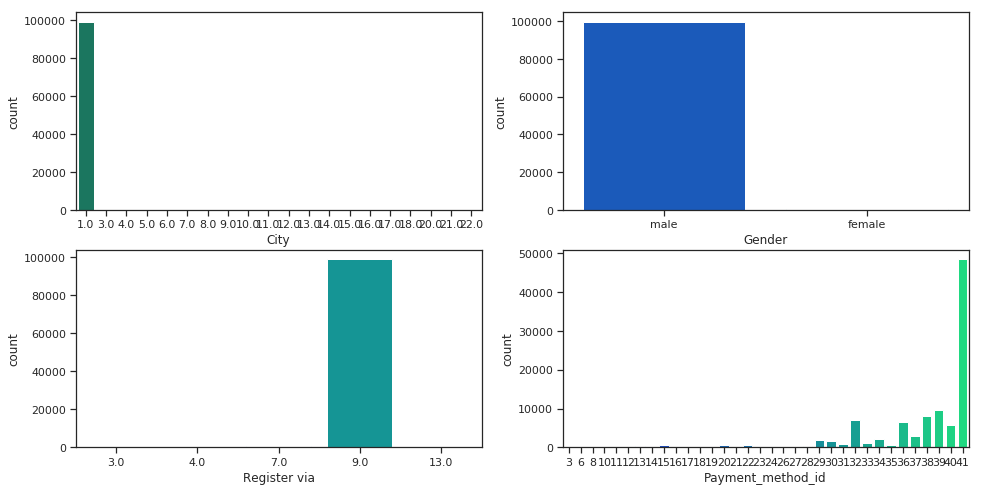

In [234]:
print(train['city'].unique())
fig,ax = plt.subplots(2,2,figsize=(16,8))
ax1,ax2,ax3,ax4 = ax.flatten()

sns.set(style="ticks")
sns.countplot(train['city'],palette='summer',ax=ax1)
#ax1.set_yscale('log')

ax1.set_xlabel('City')
#ax1.set_xticks(rotation=45)

sns.countplot(x='gender',data = train,palette='winter',ax=ax2)
#ax2.set_yscale('log')
ax2.set_xlabel('Gender')

sns.countplot(x='registered_via',data=train,palette='winter',ax=ax3)
#ax3.set_yscale('')
ax3.set_xlabel('Register via')

sns.countplot(x='payment_method_id',data= train,palette='winter',ax=ax4)
ax4.set_xlabel('Payment_method_id')



# bd  (birth day)

In [235]:
print(train['bd'].describe())

count    100000.000000
mean          0.251590
std           2.828783
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         105.000000
Name: bd, dtype: float64


Text(0.5,1,'Distribution of birth day')

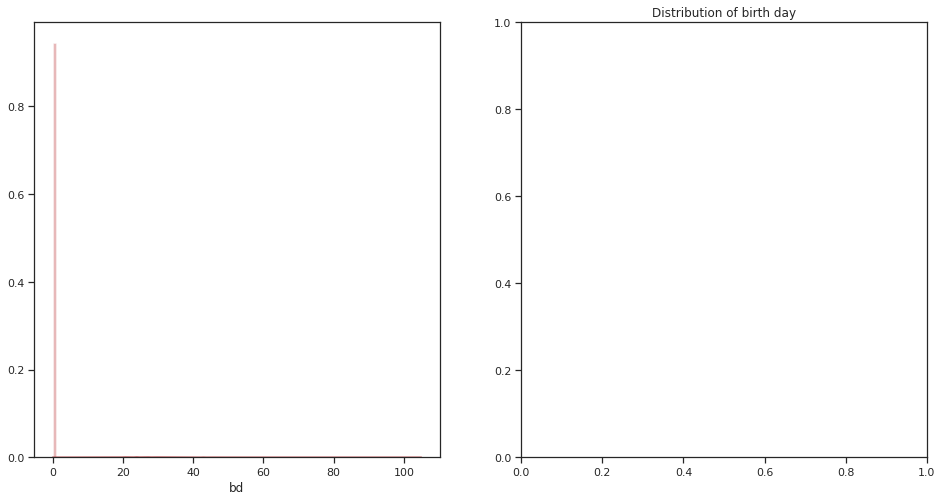

In [236]:
fig,ax = plt.subplots(1,2,figsize=(16,8))
ax1,ax2 = ax.flatten()
sns.set_style('ticks')
sns.distplot(train['bd'].fillna(train['bd'].mode()[0]),bins=100,color='r',ax=ax1)
plt.title('Distribution of birth day')

/home/sudhir/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/sudhir/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


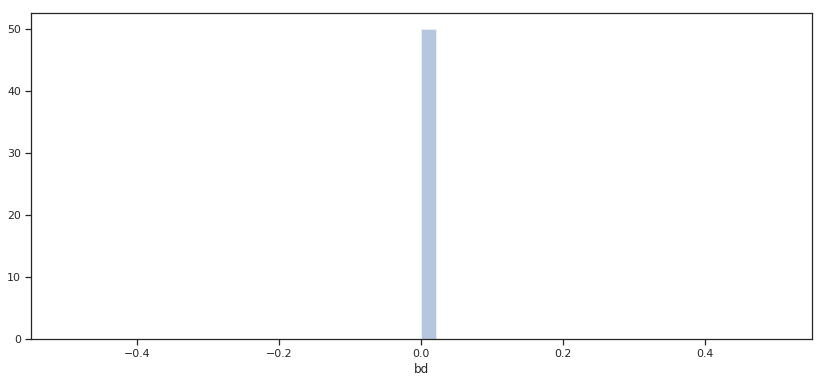

In [237]:
plt.figure(figsize=(14,6))
sns.distplot(train.loc[train['bd'].value_counts()]['bd'].fillna(0),bins=50,color='b')

# Gender

In [238]:
print(pd.crosstab(train['is_churn'],train['gender']))

gender    female   male
is_churn               
0            166  47504
1            256  52074


# registration_init_time

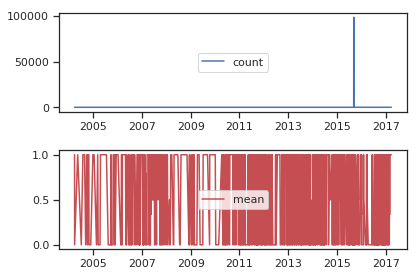

In [239]:
regi = train.groupby('registration_init_time').count()['is_churn']
plt.subplot(211)
plt.plot(regi,color='b',label='count')
plt.legend(loc='center')
regi = train.groupby('registration_init_time').mean()['is_churn']
plt.subplot(212)
plt.plot(regi,color='r',label='mean')
plt.legend(loc='center')
plt.tight_layout()

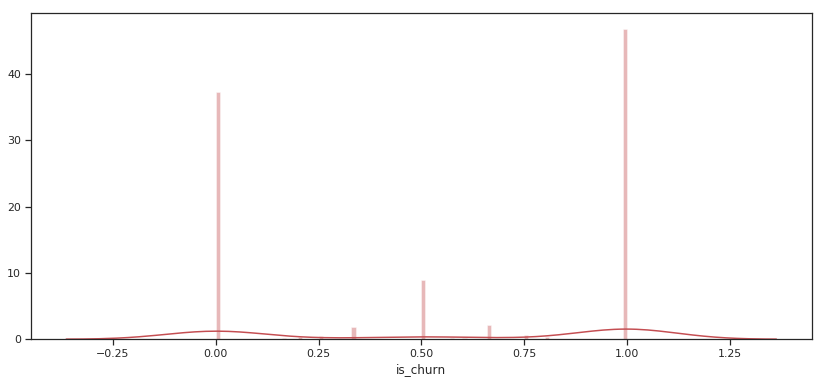

In [240]:
regi = train.groupby('registration_init_time').mean()['is_churn']
plt.figure(figsize=(14,6))
sns.distplot(regi,bins=100,color='r')

# registration

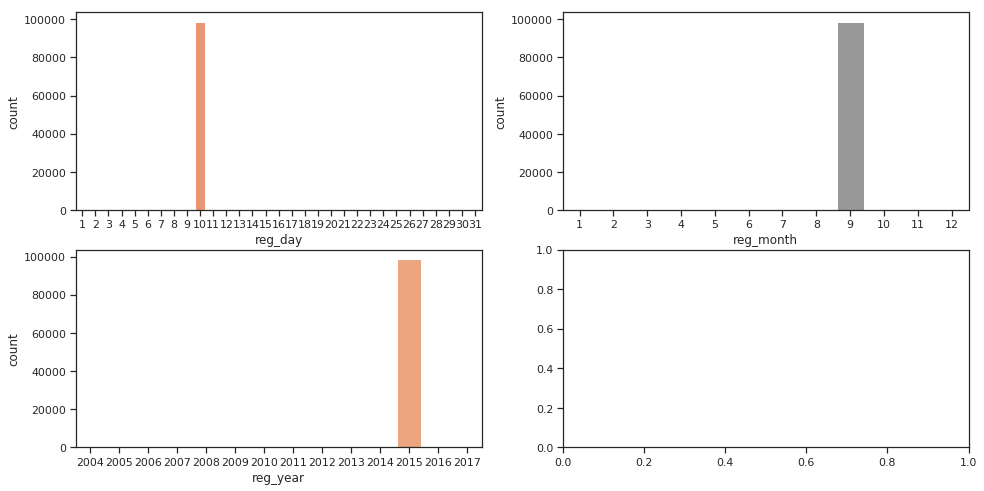

In [241]:
fig,ax = plt.subplots(2,2,figsize=(16,8))
ax1,ax2,ax3,ax4 = ax.flatten()
sns.countplot(train['reg_day'],palette='Set2',ax=ax1)
sns.countplot(data=train,x='reg_month',palette='Set1',ax=ax2)
sns.countplot(data=train,x='reg_year',palette='magma',ax=ax3)

(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,
         18.5,  19.5,  20.5,  21.5,  22.5,  23.5,  24.5,  25.5,  26.5,
         27.5,  28.5,  29.5,  30.5,  31.5,  32.5]),
 <a list of 33 Text xticklabel objects>)

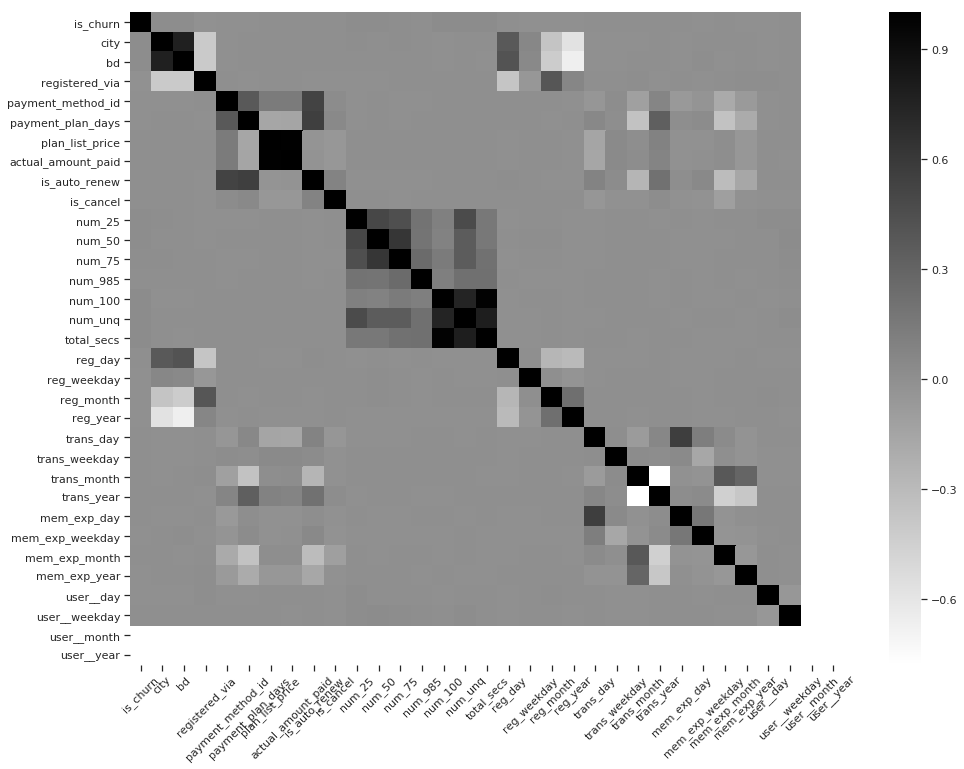

In [242]:
cor = train.corr()
plt.figure(figsize=(16,12))
sns.heatmap(cor,cmap='binary',annot=False)
plt.xticks(rotation=45)

# Encoder

In [243]:
le = LabelEncoder()
train['gender'] = le.fit_transform(train['gender'])
test['gender'] = le.fit_transform(test['gender'])

# One Hot Encoding

In [256]:
test.head()

,msno,is_churn,city,bd,gender,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,...,trans_month,trans_year,mem_exp_day,mem_exp_weekday,mem_exp_month,mem_exp_year,user__day,user__weekday,user__month,user__year
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=,0,1.0,0.0,1,7.0,2015-09-10,32,90,42,...,1,2017,4,3,5,2017,31,4,3,2017
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=,0,1.0,0.0,1,7.0,2015-09-10,41,30,-107,...,8,2015,12,4,4,2019,30,3,3,2017
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=,0,1.0,0.0,1,7.0,2015-09-10,36,30,-76,...,3,2017,22,5,4,2017,31,4,3,2017
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=,0,1.0,0.0,1,7.0,2015-09-10,36,30,-76,...,3,2017,31,4,3,2017,31,4,3,2017
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=,0,1.0,0.0,1,7.0,2015-09-10,41,30,99,...,3,2017,23,6,4,2017,31,4,3,2017


In [258]:
def OHE(df1,df2):
    #col = df.select_dtypes(include=['category']).columns
    col = ['city','gender','registered_via']
    print('Categorical columns in dataset',col)
    len_df1 = df1.shape[0]
    df = pd.concat([df1,df2],ignore_index=True)
    c2,c3 = [],{}
    for c in col:
        if df[c].nunique()>2 :
            c2.append(c)
            c3[c] = 'ohe_'+c
    
    df = pd.get_dummies(df,columns=c2,drop_first=True,prefix=c3)
    df1 = df.loc[:len_df1]
    df2 = df.loc[len_df1:]
    print(df1.shape,df2.shape)
    return df1,df2

train1, test1 = OHE(train,test)

Categorical columns in dataset ['city', 'gender', 'registered_via']
(100001, 61) (100000, 61)


# Split data set

In [259]:
unwanted = ['msno','is_churn','registration_init_time','transaction_date','membership_expire_date','date']

X = train1.drop(unwanted,axis=1)
y = train1['is_churn'].astype('category')
x_test = test1.drop(unwanted,axis=1)


## Hyper parameter tuning

In [260]:
log_reg = LogisticRegression(class_weight='balanced')
param = {'C':[0.001,0.005,0.01,0.05,0.1,0.5,1,1.5,2,3]}
rs_cv = RandomizedSearchCV(estimator=log_reg,param_distributions=param,random_state=seed)
rs_cv.fit(X,y)
print('Best parameter :{} Best score :{}'.format(rs_cv.best_params_,rs_cv.best_score_))

Best parameter :{'C': 2} Best score :0.5073449265507345


## Logistic regression model with Stratified KFold split

In [268]:
kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=seed)
pred_test_full =0
cv_score =[]
i=1
for train_index,test_index in kf.split(X,y):
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = y.loc[train_index],y.loc[test_index]
    
    #model
    lr = LogisticRegression(C=1)
    lr.fit(xtr,ytr)
    score = lr.score
    print('ROC AUC score:',score)
    cv_score.append(score)    
    pred_test = lr.predict_proba(x_test)[:,1]
    pred_test_full +=pred_test
    i+=1

1 of KFold 5
ROC AUC score: <bound method ClassifierMixin.score of LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)>
2 of KFold 5
ROC AUC score: <bound method ClassifierMixin.score of LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)>
3 of KFold 5
ROC AUC score: <bound method ClassifierMixin.score of LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)>
4 of KF

In [262]:
#lr.fit(X,y)
#lr.score(X,y)
#y_pred = lr.predict_proba(x_test)[:,1]

## Model validation

In [269]:
print(cv_score)
print('\nMean accuracy',np.mean(cv_score))
confusion_matrix(yvl,lr.predict(xvl))

[<bound method ClassifierMixin.score of LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)>, <bound method ClassifierMixin.score of LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)>, <bound method ClassifierMixin.score of LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)>, <bound method ClassifierMixin.score of LogisticRegression(C=1, class_weight=None, dual=

TypeError: unsupported operand type(s) for +: 'method' and 'method'

### Reciever Operating Charactaristics

Text(0,0.5,'True positive rate')

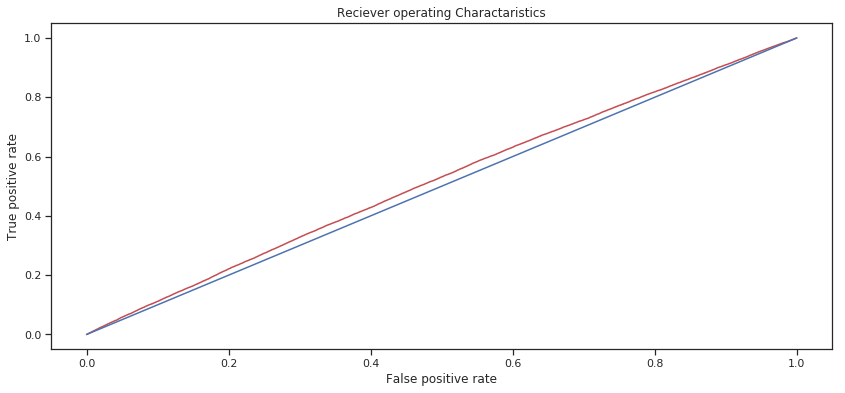

In [270]:
y_proba = lr.predict_proba(X)[:,1]
fpr,tpr,th = roc_curve(y,y_proba)

plt.figure(figsize=(14,6))
plt.plot(fpr,tpr,color='r')
plt.plot([0,1],[0,1],color='b')
plt.title('Reciever operating Charactaristics')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

## Predict for unseen data set

In [273]:
y_pred = pred_test_full/kf.n_splits
submit = pd.DataFrame({'msno':test['msno'],'is_churn':y_pred})
submit.to_csv('kk_pred.csv',index=False)
#submit.to_csv('kk_pred.csv.gz',index=False,compression='gzip')
submit.head()

,msno,is_churn
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=,0.516162
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=,0.509455
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=,0.553427
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=,0.595025
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=,0.539090


# Thank you for visiting